**Table of contents**<a id='toc0_'></a>    
- 1. [Preface        ](#toc1_)    
- 2. [Load datasets       ](#toc2_)    
  - 2.1. [Load earthquake catalog       ](#toc2_1_)    
  - 2.2. [Load PNSN tremor catalog (Wech)       ](#toc2_2_)    
    - 2.2.1. [(Pick the line on which events are projected, optional, can load)       ](#toc2_2_1_)    
  - 2.3. [Select earthquakes in the tremor region       ](#toc2_3_)    
  - 2.4. [Load tremoscope catalog       ](#toc2_4_)    
- 3. [Explicit cluster detection   ](#toc3_)    
  - 3.1. [Cluster detection   ](#toc3_1_)    
  - 3.2. [Just one zone  ](#toc3_2_)    
  - 3.3. [Across the whole region](#toc3_3_)    
- 4. [A few synchronicity measures tests      ](#toc4_)    
  - 4.1. [Correlation matrix / distance     ](#toc4_1_)    
    - 4.1.1. [Try for two bins only    ](#toc4_1_1_)    
    - 4.1.2. [Computing cross-correlation matrix    ](#toc4_1_2_)    
    - 4.1.3. [Measuring correlation distance in the matrix    ](#toc4_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Preface         [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import requests
import io

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from geostuff import transect

# 2. <a id='toc2_'></a>Load datasets        [&#128285;](#toc0_)

In [2]:
# Constants for everyone
day0 = np.datetime64('2009-08-01')

## 2.1. <a id='toc2_1_'></a>Load earthquake catalog        [&#128285;](#toc0_)

In [3]:
# Download usgs catalog
# Format
format_usgs = "format=csv"
format_isc = "format=text"  # something that looks like csv

# Date range
t0 = "2009-08-01"
t1 = "2024-04-04"
date_range = f"starttime={t0}&endtime={t1}" 

# Geographic range
minlat = 39
maxlat = 54
minlon = -128
maxlon = -121
geographic_range = f"minlatitude={minlat}&maxlatitude={maxlat}&minlongitude={minlon}&maxlongitude={maxlon}"

# Magnitude range
minmag = 1.6
mag_range = f"minmagnitude={minmag}"

# Event-type
event_type = "eventtype=earthquake"

url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?{format_usgs}&{date_range}&{geographic_range}&{mag_range}&{event_type}"  # pb with this one is the limit of 20k events
# url = f"https://www.isc.ac.uk/fdsnws/event/1/query?{format_isc}&{date_range}&{geographic_range}"
print(url)
stream = requests.get(url).content

names = ["time", "lat", "lon", "depth", "mag", "magType", "nst", "gap", "dmin", "rms", "net", "id", "updated", "place", "type", "horizontalError", "depthError", "magError", "magNst", "status", "locationSource", "magSource"]
eq = pd.read_csv(io.StringIO(stream.decode('utf-8')), names=names, skiprows=1)
eq['date'] = pd.to_datetime(eq['time'])

https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2009-08-01&endtime=2024-04-04&minlatitude=39&maxlatitude=54&minlongitude=-128&maxlongitude=-121&minmagnitude=1.6&eventtype=earthquake


## 2.2. <a id='toc2_2_'></a>Load PNSN tremor catalog (Wech)        [&#128285;](#toc0_)

In [4]:
# Load tremor
path = workdir + 'projects/data/Catalogs/cascadia_tremor/tremor_all_cascadia_09_24.csv'
names = ['lat', 'lon', 'depth', 'starttime', 'energy', 'duration']
tremor = pd.read_csv(path, names=names, skiprows=1)
tremor['date'] = pd.to_datetime(tremor['starttime'])

# Find str in duration of tremor and convert them to float by stripping the space and converting to float (still misses some ' None ', don't know what to do with them...)
tremor.duration = tremor.duration.apply(lambda x: float(x.strip()) if x is str else x)

# Sort tremor by date
tremor = tremor.sort_values('date')

# Compute the day in the sequence for tremor
day0 = np.datetime64('2009-08-01')
tremor['day'] = (tremor.date - day0) / np.timedelta64(1, 'D')

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_3728/3805188776.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tremor = pd.read_csv(path, names=names, skiprows=1)


### 2.2.1. <a id='toc2_2_1_'></a>(Pick the line on which events are projected, optional, can load)        [&#128285;](#toc0_)

In [5]:
# # Select points that define tremor region 
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# # Create an empty array to store the picked locations
# picked_locations = []
# # Define the on_click event handler function
# def on_click(event):
#     if event.inaxes == ax:
#         # Get the latitude and longitude of the clicked point
#         lat, lon = event.ydata, event.xdata
#         picked_locations.append((lat, lon))
#         print(f"Point picked: Latitude={lat}, Longitude={lon}")

#         ax.plot([pl[1] for pl in picked_locations], [pl[0] for pl in picked_locations], 'ro-', transform=ccrs.PlateCarree())
#         plt.draw()

# # Connect the on_click event handler to the figure
# fig.canvas.mpl_connect('button_press_event', on_click)

# # Add coastlines
# ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# # Add states
# ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# # Add tremor
# ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, linestyle='--')
# gl.top_labels = False
# gl.right_labels = False
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()

# # Set extent for Cascadia subduction zone
# extent = [-128, -121, 39, 52]
# ax.set_extent(extent)

In [6]:
# # Save picked locations
# plt.close()

# picked_locations = np.array(picked_locations)
# np.savetxt('data/cascadia/tremor_region_line.txt', picked_locations)

## 2.3. <a id='toc2_3_'></a>Select earthquakes in the tremor region        [&#128285;](#toc0_)

In [7]:
# Project onto a straight line
# --> Define center line of tremor
lat_center = np.arange(39, 52, 0.2)
dlat = 0.4
center_line = np.zeros((len(lat_center), 2))

for ii, lat in enumerate(lat_center):
    lat_min = lat - dlat
    lat_max = lat + dlat
    tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
    center_line[ii, 1] = (lat_min + lat_max) / 2
    center_line[ii, 0] = tremor_bin.lon.median()

# --> Fit it with a straight line to find the transect points
p = np.polyfit(center_line[~np.isnan(center_line[:, 0]), 1], center_line[~np.isnan(center_line[:, 0]), 0], 1)
N_point = p[0] * 52 + p[1]
S_point = p[0] * 39 + p[1]
transect_line = {'N':{'lat': 52, 'lon': N_point}, 'S': {'lat': 39, 'lon': S_point}}

# plt.figure()
# plt.plot(center_line[:, 0], center_line[:, 1])
# plt.plot([transect_line['N']['lon'], transect_line['S']['lon']], [transect_line['N']['lat'], transect_line['S']['lat']])
# plt.show()

# --> Project earthquakes onto the line
t = transect(eq.lon.values, eq.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
eq['xf'] = t[0]
eq['yf'] = t[1]

# --> Project tremor onto the line
t = transect(tremor.lon.values, tremor.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
tremor['xf'] = t[0]
tremor['yf'] = t[1]


In [8]:
# # To project onto more complex curve
# # for instance taking the median longitude of tremor for latitude bins
# # https://stackoverflow.com/questions/67490884/distance-between-a-point-and-a-curve-in-python
# # Even better, for better 

# # --> Define center line of tremor
# lat_center = np.arange(39, 52, 0.2)
# dlat = 0.4
# center_line = np.zeros((len(lat_center), 2))

# for ii, lat in enumerate(lat_center):
#     lat_min = lat - dlat
#     lat_max = lat + dlat
#     tremor_bin = tremor[tremor.lat.between(lat_min, lat_max)]
#     center_line[ii, 1] = (lat_min + lat_max) / 2
#     center_line[ii, 0] = tremor_bin.lon.median()

# plt.figure()
# plt.plot(center_line[:, 0], center_line[:, 1], 'r--')
# plt.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5)
# plt.show()

# # --> Find the closest point on the line to each earthquake
# def distance(x, y, x0, y0):
#     "(x,y) line to consider, (x0, y0) sample point (event)"
#     d_x = x - x0
#     d_y = y - y0
#     dis = d_x**2 + d_y**2  # speeds it up to not take the sqrt
#     return dis


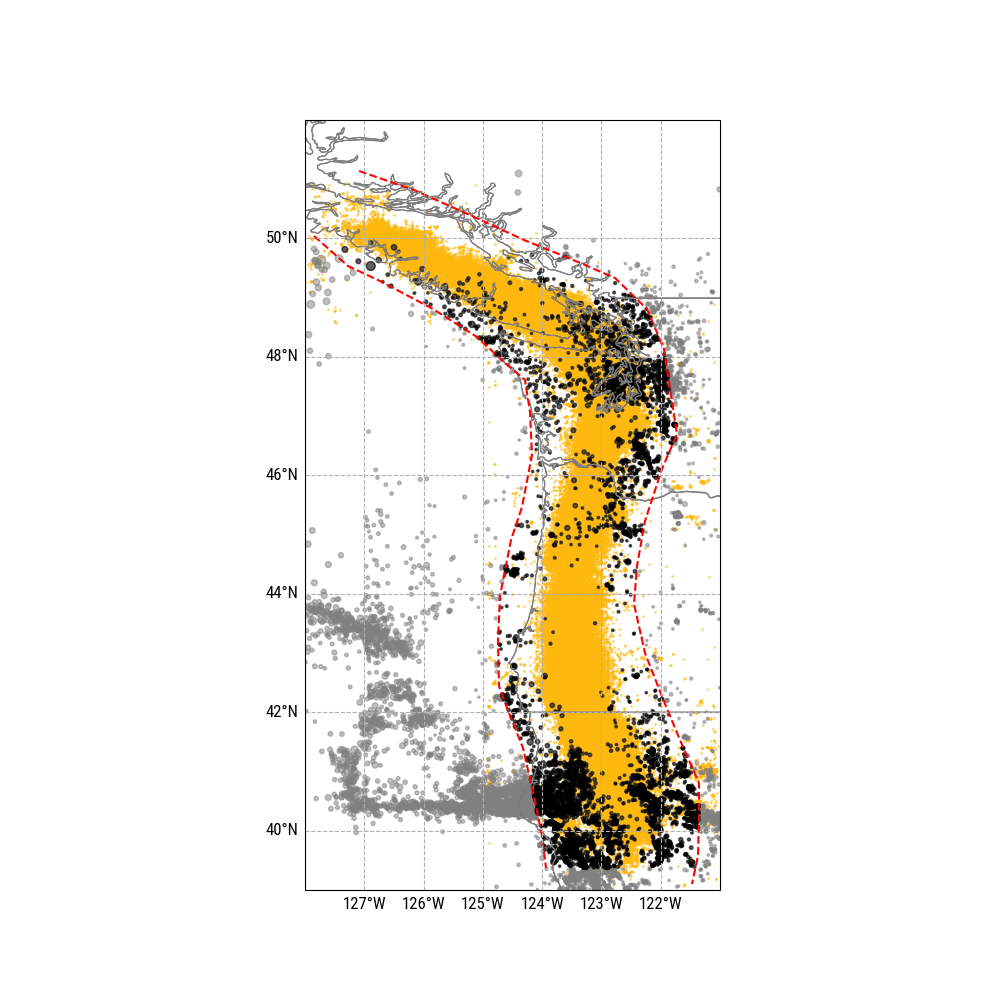

In [9]:
# Find which points are left or right of the line drawn on the map
east_line = np.loadtxt('data/cascadia/tremor_region_east_line.txt')
west_line = np.loadtxt('data/cascadia/tremor_region_west_line.txt')

# For each earthquake
def which_side(M, A, B):
    return np.sign((B[0] - A[0]) * (M[1] - A[1]) - (B[1] - A[1]) * (M[0] - A[0]))

# For each earthquake, find the points of the line it's longitude is between, and then using those points, find if the earthquake is left or right of the line
eq['east'] = np.zeros(len(eq))
eq['west'] = np.zeros(len(eq))
for ii, row in eq.iterrows():
    M = (row['lon'], row['lat'])
    for jj in range(len(east_line)-1):
        A = (east_line[jj][1], east_line[jj][0])
        B = (east_line[jj+1][1], east_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'east'] = side
    for jj in range(len(west_line)-1):
        A = (west_line[jj][1], west_line[jj][0])
        B = (west_line[jj+1][1], west_line[jj+1][0])
        if (A[1] <= M[1] <= B[1]) or (B[1] <= M[1] <= A[1]):
            side = which_side(M, A, B)
            eq.at[ii, 'west'] = side

eq_near = eq[(eq.east == -1) & (eq.west == 1)]

%matplotlib widget
# Map of data
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)

# Add states
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='.5', linewidth=1)

# Add earthquakes
ax.scatter(eq.lon, eq.lat, s=eq.mag**2, color='.5', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(eq_near.lon, eq_near.lat, s=eq_near.mag**2, color='k', alpha=0.5, transform=ccrs.PlateCarree(), zorder=1)

# Add tremor
ax.scatter(tremor.lon, tremor.lat, s=1, color='C2', alpha=0.5, transform=ccrs.PlateCarree(), zorder=0)

# Show east and west lines
ax.plot(east_line[:, 1], east_line[:, 0], 'r--', transform=ccrs.PlateCarree())
ax.plot(west_line[:, 1], west_line[:, 0], 'r--', transform=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Set extent for Cascadia subduction zone
extent = [-128, -121, 39, 52]
ax.set_extent(extent)

plt.show()

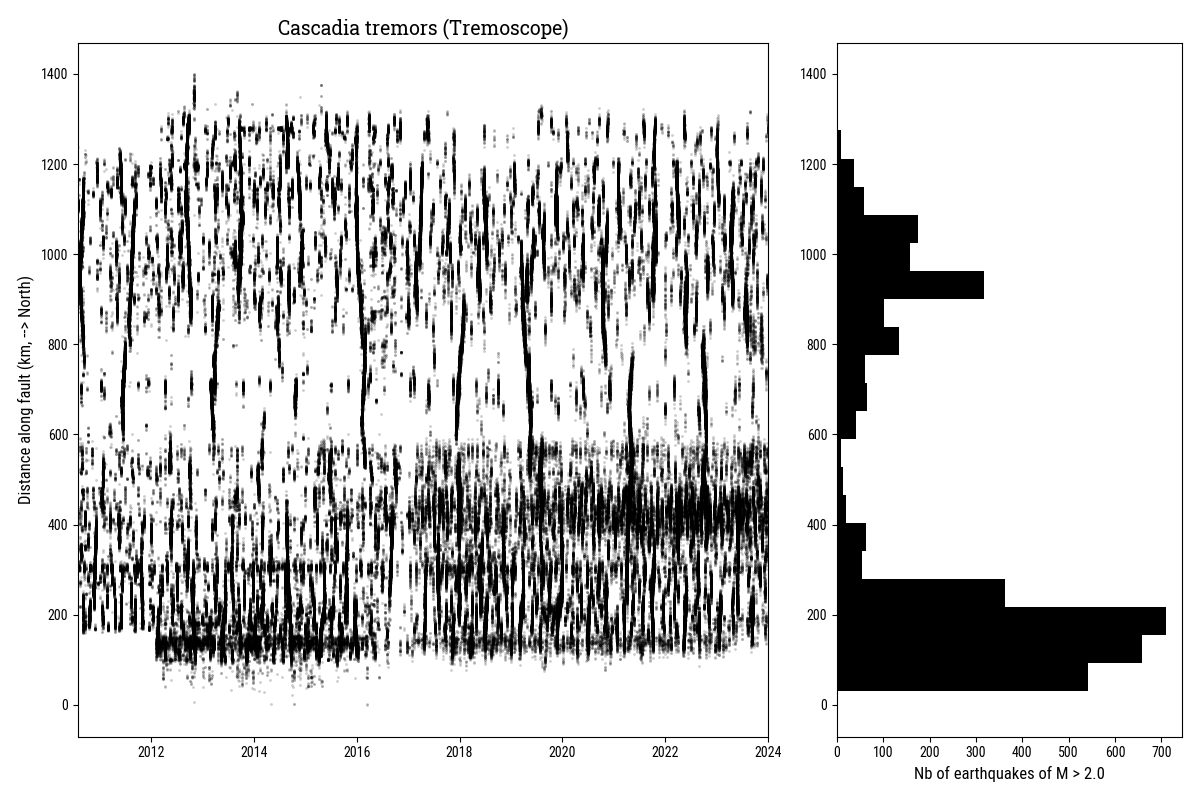

In [10]:
# Plot
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Cascadia tremors (Tremoscope)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(tremor.date, tremor.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=2)

ax.set_xlim(np.datetime64('2010-08-01'), np.datetime64('2024-01-01'))

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq_near.xf[eq_near.mag > min_m], bins=20, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()

In [173]:
xmax = 800
xmin = 600

np.savetxt('trem_{:}_{:}.txt'.format(xmin, xmax), tremor[(tremor.xf > xmin) & (tremor.xf < xmax)][['day', 'xf']].values)

## 2.4. <a id='toc2_4_'></a>Load tremoscope catalog        [&#128285;](#toc0_)

330924 tremor detections, spanning 2005--2014


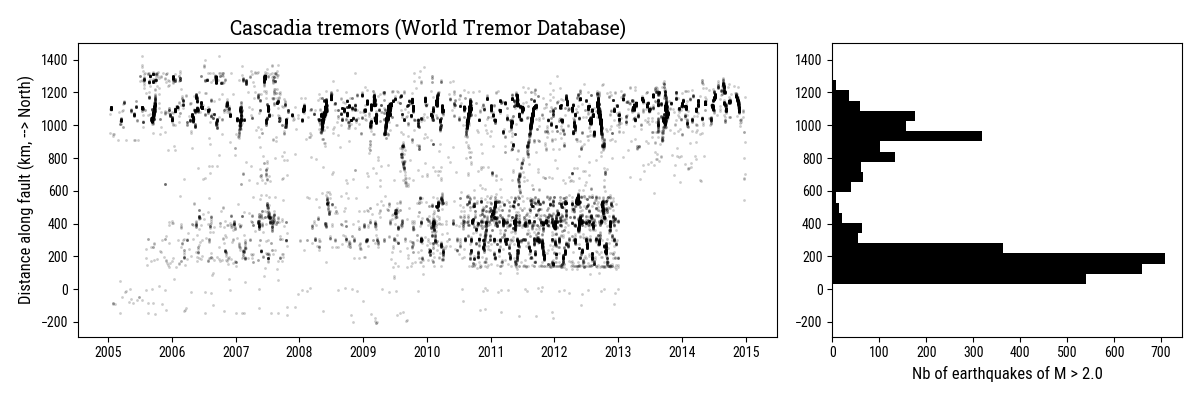

In [11]:
# World tremor database
path = workdir + 'projects/data/Catalogs/world_tremor_database/cascadia_wtb_0514.csv'

COLS = ['date', 'time', 'lat', 'lon', 'depth', 'mag', 'dur', 'err', 'optional_date']
wtd = pd.read_csv(
    path,
    names=COLS,
)

wtd['date_str'] = wtd.date.values + ' ' + wtd.time.values
wtd['date'] = pd.to_datetime(wtd.date_str)
day0 = np.datetime64('2005-01-01')
wtd['day'] = (wtd.date - day0) / np.timedelta64(1, 'D')

wtd.sort_values(by=["date"], inplace=True)
print('{:d} tremor detections, spanning {:d}--{:d}'.format(wtd.size, wtd.date.min().year, wtd.date.max().year))

# Project tremors on the fault
t = transect(wtd.lon.values, wtd.lat.values, transect_line['S']['lon'], transect_line['S']['lat'], transect_line['N']['lon'], transect_line['N']['lat'])
wtd['xf'] = t[0]
wtd['yf'] = t[1]

# Plot
fig = plt.figure(figsize=(12, 4))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

ax = fig.add_subplot(gs[0, 0])
ax.set_title('Cascadia tremors (World Tremor Database)', fontname='Roboto Slab', fontsize=14)
ax.set_ylabel('Distance along fault (km, --> North)')

ax.plot(wtd.date, wtd.xf, 'o', mec=[0,0,0,0], mfc=to_rgba('k', .2), ms=2)

ax = fig.add_subplot(gs[0, 1], sharey=ax)
min_m = 2
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.hist(eq_near.xf[(eq_near.mag > min_m)], bins=20, orientation='horizontal', color=to_rgba('k'))

plt.tight_layout()
plt.show()

---

# 3. <a id='toc3_'></a>Explicit cluster detection    [&#128285;](#toc0_)

## 3.1. <a id='toc3_1_'></a>Cluster detection    [&#128285;](#toc0_)

Good parameters:
- DBSCAN: `x0 = 7 days`, `t0 = 50 km`, `eps=.5 km`, `min_samples=20`

In [314]:
from sklearn.cluster import DBSCAN

Detected 1715 clusters
Detected 1715 clusters
Min, median, max number of LFEs in a cluster: 18, 72.0, 15488


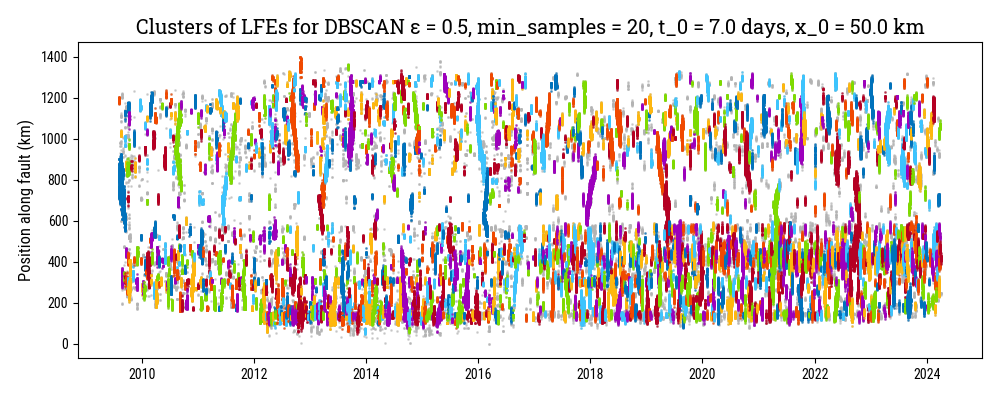

In [185]:
# Parameters for cluster detection
ev_x = tremor['xf'].values
ev_t = tremor['day'].values

t0 = 7. # scaling factor for time (in days)
x0 = 50. # scaling factor for position (in km) 

X = np.column_stack([ev_x / x0, ev_t / t0])

# Parameters for the clustering model
dbs = DBSCAN(eps=.5, min_samples=20)

# t0=48h, x0=20km, eps=.5 and min_samples=100 gives good clusters

# Fit the model
clusters_fit = dbs.fit(X)

print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))

# Stats on the clusters
print('Detected {:d} clusters'.format(len(np.unique(clusters_fit.labels_))))
print('Min, median, max number of LFEs in a cluster: {:}, {:}, {:}'.format(np.min(np.bincount(clusters_fit.labels_+1)[1:]), np.median(np.bincount(clusters_fit.labels_+1)[1:]), np.max(np.bincount(clusters_fit.labels_+1)[1:])))

# Show clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Clusters of LFEs for DBSCAN ε = {:}, min_samples = {:}, t_0 = {:} days, x_0 = {:} km'.format(dbs.eps, dbs.min_samples, t0, x0), fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')
# ax.set_xlim(np.datetime64('2018-01-01'), np.datetime64('2019-01-01'))

ax.plot(tremor.date, tremor.xf, 'o', ms=1, alpha=0.5, c='.7')

for cluster in np.unique(clusters_fit.labels_):
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(tremor.date.values[idx], tremor.xf.values[idx], 'o', ms=1, alpha=0.5)
plt.tight_layout()
plt.show()

In [194]:
# Make clusters dataframe
tremor['cluster_id'] = clusters_fit.labels_

# Group LFEs by cluster ID
cluster_groups = tremor.groupby('cluster_id')

# Initialize an empty dataframe to store cluster information
clusters_df = pd.DataFrame(columns=['id',
                                    'n_ev',
                                    't_first',
                                    't_last',
                                    'x_min',
                                    'x_max',
                                    'z_min',
                                    'z_max',
                                    't_centroid',
                                    'x_centroid',
                                    'z_centroid',
                                    't_first80',
                                    't_last80',
                                    'x_min90',
                                    'x_max90',
                                    'duration80'])

# Loop over the cluster groups and compute statistics for each cluster
for cluster_id, cluster_data in cluster_groups:
    if cluster_id == -1:
        continue
    n_ev = len(cluster_data)
    t_first = cluster_data['date'].min()
    t_last = cluster_data['date'].max()
    x_min = cluster_data['xf'].min()
    x_max = cluster_data['xf'].max()
    z_min = cluster_data['depth'].min()
    z_max = cluster_data['depth'].max()
    t_centroid = np.percentile(cluster_data['date'], 50)
    x_centroid = np.median(cluster_data['xf'])
    z_centroid = np.median(cluster_data['depth'])
    t_first80 = np.percentile(cluster_data['date'], 10)
    t_last80 = np.percentile(cluster_data['date'], 90)
    x_min90 = np.percentile(cluster_data['xf'], 5)
    x_max90 = np.percentile(cluster_data['xf'], 95)
    duration80 = (t_last80 - t_first80) / np.timedelta64(1, 's')  # in seconds
    span90 = x_max90 - x_min90

    # Add cluster information to the dataframe
    clusters_df.loc[len(clusters_df)] = [cluster_id, n_ev, t_first, t_last, x_min, x_max, z_min, z_max, t_centroid, x_centroid, z_centroid, t_first80, t_last80, x_min90, x_max90, duration80] 

## 3.2. <a id='toc3_2_'></a>Just one zone   [&#128285;](#toc0_)

In [253]:
# Define bin and select clusters
bin_xmin = 400
bin_xmax = 600

q_min_span = .66  # proportion of bin to span for cluster to be considere

fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

selected_clusters = clusters_df[bin_spanning_clusters]

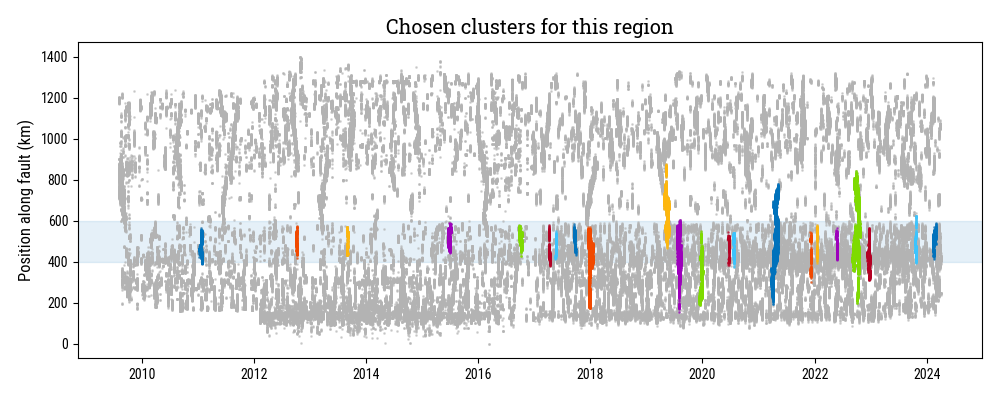

In [254]:
# Show
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.set_title('Chosen clusters for this region', fontname='Roboto Slab')
ax.set_ylabel('Position along fault (km)')

ax.axhspan(bin_xmin, bin_xmax, color='C0', alpha=.1)

ax.plot(tremor.date, tremor.xf, 'o', ms=1, alpha=0.5, c='.7')

for cluster in selected_clusters.id:
    if cluster == -1:
        continue
    idx = clusters_fit.labels_ == cluster
    ax.plot(tremor.date.values[idx], tremor.xf.values[idx], 'o', ms=1, alpha=0.5)
plt.tight_layout()
plt.show()

In [255]:
# Compute different measures of synchronization
# --> Clustering index: how many events that occur in this bin are within the selected clusters for this bin
n_ev_in_bin = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax)])
n_ev_in_clusters = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax) & np.in1d(tremor.cluster_id.values, selected_clusters.id.values)])

print('Proportion of events in bin-spanning clusters: {:.2f}\n'.format(n_ev_in_clusters / n_ev_in_bin))

# --> Periodicity detection and its COV
selected_clusters_dT = np.diff(selected_clusters.t_centroid.values) / np.timedelta64(1, 'D')
mean_dT = np.mean(selected_clusters_dT)
std_dT = np.std(selected_clusters_dT)
cov_dT = std_dT / mean_dT

print('Mean period: {:.2f} days ({:.2f} months)'.format(mean_dT, mean_dT / 30.5))
print('Standard deviation of period: {:.2f} days ({:.2f} months)'.format(std_dT, mean_dT / 30.5))
print('Coefficient of variation of period (periodicity): {:.2f}'.format(cov_dT))

Proportion of events in bin-spanning clusters: 0.38

Mean period: 227.27 days (7.45 months)
Standard deviation of period: 183.94 days (7.45 months)
Coefficient of variation of period (periodicity): 0.81


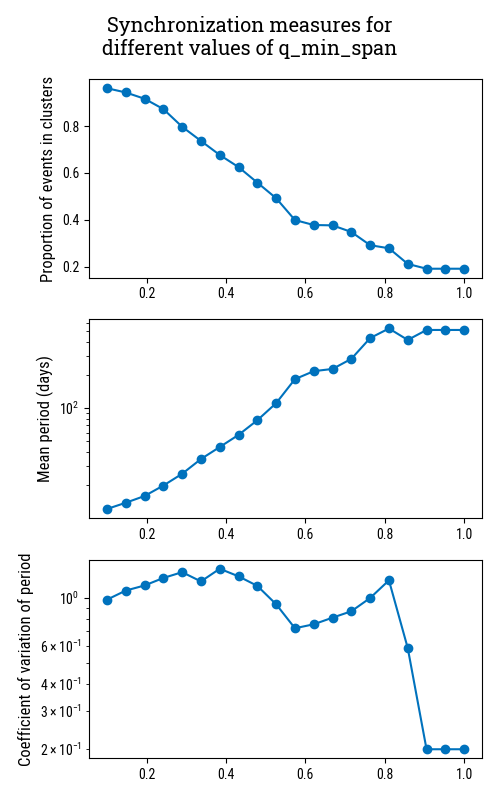

In [256]:
# For one bin, try different values of q_min_span
q_min_spans = np.linspace(.1, 1., 20)

# Initialize empty arrays to store the results
prop_in_clusters = np.zeros_like(q_min_spans)
mean_periods = np.zeros_like(q_min_spans)
std_periods = np.zeros_like(q_min_spans)
cov_periods = np.zeros_like(q_min_spans)

for ii, q_min_span in enumerate(q_min_spans):
    # Define bin and select clusters
    fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
    xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
    xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

    cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

    size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

    bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

    selected_clusters = clusters_df[bin_spanning_clusters]

    # Compute different measures of synchronization
    # --> Clustering index: how many events that occur in this bin are within the selected clusters for this bin
    n_ev_in_bin = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax)])
    n_ev_in_clusters = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax) & np.in1d(tremor.cluster_id.values, selected_clusters.id.values)])

    prop_in_clusters[ii] = n_ev_in_clusters / n_ev_in_bin

    # --> Periodicity detection and its COV
    selected_clusters_dT = np.diff(selected_clusters.t_centroid.values) / np.timedelta64(1, 'D')
    mean_dT = np.mean(selected_clusters_dT)
    std_dT = np.std(selected_clusters_dT)
    cov_dT = std_dT / mean_dT

    mean_periods[ii] = mean_dT
    std_periods[ii] = std_dT
    cov_periods[ii] = cov_dT

# Plot
fig, ax = plt.subplots(3, 1, figsize=(5, 8))
fig.suptitle('Synchronization measures for\ndifferent values of q_min_span', fontname='Roboto Slab')

ax[0].plot(q_min_spans, prop_in_clusters, 'o-')
ax[0].set_ylabel('Proportion of events in clusters')

ax[1].plot(q_min_spans, mean_periods, 'o-')
ax[1].set_ylabel('Mean period (days)')
ax[1].set_yscale('log')

ax[2].plot(q_min_spans, cov_periods, 'o-')
ax[2].set_ylabel('Coefficient of variation of period')
ax[2].set_yscale('log')

plt.tight_layout()
plt.show()


## 3.3. <a id='toc3_3_'></a>Across the whole region [&#128285;](#toc0_)


In [312]:
# Parameters

q_min_span = .3  # proportion of bin to span for cluster to be considered

xmin = 200  # in km, the northern limit of the binning
xmax = 1200  # in km, the southern limit of the binning

wbin = 100  # in km, the width of the bin
ovlp = .5  # proportion of overlap between bins

bin_xmins = np.arange(xmin, xmax - wbin*ovlp , wbin * (1 - ovlp))
bin_xmaxs = bin_xmins + wbin

# Initialize empty arrays to store the results
prop_in_clusters = np.zeros_like(bin_xmins)
mean_periods = np.zeros_like(bin_xmins)
std_periods = np.zeros_like(bin_xmins)
cov_periods = np.zeros_like(bin_xmins)

for ii, (bin_xmin, bin_xmax) in enumerate(zip(bin_xmins, bin_xmaxs)):
    # Select clusters in bin
    fully_cross_bin = (clusters_df.x_min <= bin_xmin) & (clusters_df.x_max >= bin_xmax)
    xmax_in_bin = (clusters_df.x_max >= bin_xmin) & (clusters_df.x_max <= bin_xmax)
    xmin_in_bin = (clusters_df.x_min >= bin_xmin) & (clusters_df.x_min <= bin_xmax)

    cluster_in_bin = fully_cross_bin | xmax_in_bin | xmin_in_bin

    size_in_bin = np.array([min(bin_xmax, clust_xmax) for clust_xmax in clusters_df.x_max]) - np.array([max(bin_xmin, clust_xmin) for clust_xmin in clusters_df.x_min])

    bin_spanning_clusters = cluster_in_bin & (size_in_bin >= q_min_span * (bin_xmax - bin_xmin))

    selected_clusters = clusters_df[bin_spanning_clusters]

    # Compute different measures of synchronization
    # --> Clustering index: how many events that occur in this bin are within the selected clusters for this bin
    n_ev_in_bin = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax)])
    n_ev_in_clusters = len(tremor[(tremor.xf >= bin_xmin) & (tremor.xf <= bin_xmax) & np.in1d(tremor.cluster_id.values, selected_clusters.id.values)])

    prop_in_clusters[ii] = n_ev_in_clusters / n_ev_in_bin

    # --> Periodicity detection and its COV
    selected_clusters_dT = np.diff(selected_clusters.t_centroid.values) / np.timedelta64(1, 'D')
    mean_dT = np.mean(selected_clusters_dT)
    std_dT = np.std(selected_clusters_dT)
    cov_dT = std_dT / mean_dT

    mean_periods[ii] = mean_dT
    std_periods[ii] = std_dT
    cov_periods[ii] = cov_dT

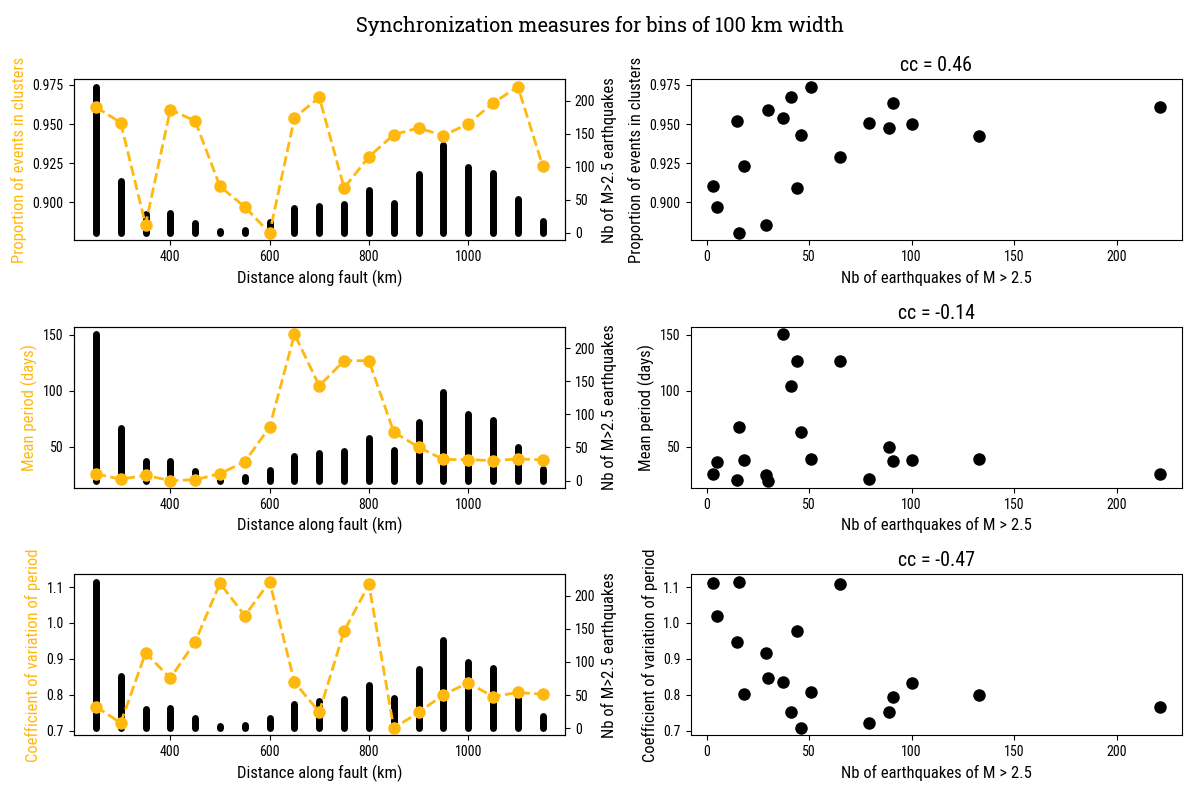

In [313]:
# Plot
mag_min = 2.5
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Synchronization measures for bins of {:} km width'.format(wbin), fontname='Roboto Slab')

axes[0, 0].plot(bin_xmins + wbin/2, prop_in_clusters, 'o--', c='C2', ms=8, lw=2)
axes[0, 0].set_ylabel('Proportion of events in clusters', c='C2')
axes_1 = []
axes_1.append(axes[0, 0])

axes[1, 0].plot(bin_xmins + wbin/2, mean_periods, 'o--', c='C2', ms=8, lw=2)
axes[1, 0].set_ylabel('Mean period (days)', c='C2')
axes_1.append(axes[1, 0])

axes[2, 0].plot(bin_xmins + wbin/2, cov_periods, 'o--', c='C2', ms=8, lw=2)
axes[2, 0].set_ylabel('Coefficient of variation of period', c='C2')
axes_1.append(axes[2, 0])

for ax in axes_1:
    ax_eq = ax.twinx()
    # count earthquakes in each bin
    eq_in_bin = np.array([len(eq_near[(eq_near.xf >= bin_xmin) & (eq_near.xf <= bin_xmax) & (eq_near.mag > mag_min)]) for bin_xmin, bin_xmax in zip(bin_xmins, bin_xmaxs)])
    X, Y = [], []
    for x,y in zip(bin_xmins + wbin/2, eq_in_bin):
        X.extend([x, x, None]), Y.extend([0, y, None])
    ax_eq.plot(X, Y, c='k', lw=5, solid_capstyle='round')
    ax.set_zorder(ax_eq.get_zorder()+1)
    ax.patch.set_visible(False)
    ax_eq.set_ylabel('Nb of M>{:.1f} earthquakes'.format(mag_min), color='k')

    ax.set_xlabel('Distance along fault (km)')


axes[0, 1].plot(eq_in_bin, prop_in_clusters, 'o', c='k', ms=8, lw=2)
axes[0, 1].set_ylabel('Proportion of events in clusters', c='k')
axes[0, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[0, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, prop_in_clusters)[0, 1]))

axes[1, 1].plot(eq_in_bin, mean_periods, 'o', c='k', ms=8, lw=2)
axes[1, 1].set_ylabel('Mean period (days)', c='k')
axes[1, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[1, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, mean_periods)[0, 1]))

axes[2, 1].plot(eq_in_bin, cov_periods, 'o', c='k', ms=8, lw=2)
axes[2, 1].set_ylabel('Coefficient of variation of period', c='k')
axes[2, 1].set_xlabel('Nb of earthquakes of M > {:.1f}'.format(mag_min))
axes[2, 1].set_title('cc = {:.2f}'.format(np.corrcoef(eq_in_bin, cov_periods)[0, 1]))


plt.tight_layout()
plt.show()

---

# 4. <a id='toc4_'></a>A few synchronicity measures tests       [&#128285;](#toc0_)

## 4.1. <a id='toc4_1_'></a>Correlation matrix / distance      [&#128285;](#toc0_)

### 4.1.1. <a id='toc4_1_1_'></a>Try for two bins only     [&#128285;](#toc0_)

In [160]:
from stats import cross_corr
import scipy.signal as ssg

In [165]:
# Cross-corr of just 2 bins
bin1 = [600, 620]
bin2 = [700, 720]

tremor_in_bin1 = tremor.xf.between(bin1[0], bin1[1])
tremor_in_bin2 = tremor.xf.between(bin2[0], bin2[1])

delta = 1

count_bin1 = np.histogram(tremor[tremor_in_bin1].day.values, bins=np.arange(0, tremor.day.max()+delta, delta))[0]
count_bin2 = np.histogram(tremor[tremor_in_bin2].day.values, bins=np.arange(0, tremor.day.max()+delta, delta))[0]

cc, lag = cross_corr(count_bin1, count_bin2, delta, norm=True, no_bias=True)

# Folding around 0 to get something symmetrical
fig, ax = plt.subplots()
ax.plot(lag, (cc+cc[::])/2)
plt.show()

### 4.1.2. <a id='toc4_1_2_'></a>Computing cross-correlation matrix     [&#128285;](#toc0_)

Two versions:
- bins with no overlap (easier to interpret)
- bins with overlap (smoother)

In [152]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 20  # in km, width of bin
xmin_bin = 200
xmax_bin = 1200
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = False
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 2*dx_bin  # in km/day

In [153]:
# Make the matrix of cross-correlation — Computation
# --> Make the counts
count_time = np.arange(0, tremor.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    tremor_in_bin = tremor.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(tremor[tremor_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
            
            if look_both_ways:
                cc = (cc + cc[::-1]) / 2
                cc = cc[lag >= 0]
                lag = lag[lag >= 0]
            
            in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii]) - (x_bin_edges[jj+1] + x_bin_edges[jj]) / 2) / v_min
            cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
            lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]
            # cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc)
            # lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[np.argmax(cc)]

In [154]:
# # Make the matrix of cross-correlation — Parameters
# # --> Define the spatial bins
# w_bin = 50  # in km, width of bin
# dx_bin = 10  # in km, width of bin
# xmin_bin = 200
# xmax_bin = 1200
# x_bin_centers = np.arange(xmin_bin + w_bin/2, xmax_bin + w_bin/2 + dx_bin, dx_bin)

# # --> Parameters for the temporal counts
# delta = 1  # in days, width of the temporal bin to count tremor events

# # --> Parameters for the correlation
# norm = True
# no_bias = True
# look_both_ways = True  # to add the negative lags to the positive

# # --> Minimum speed of communication to consider (affects where we look for maximum lag)
# v_min = 1.  # in km/day

In [155]:
# # Make the matrix of cross-correlation — Computation
# # --> Make the counts
# count_time = np.arange(0, tremor.day.max()+delta, delta)
# counts = np.zeros((len(x_bin_centers), len(count_time)-1))

# for ii in range(len(x_bin_centers)):
#     x_min = x_bin_centers[ii] - w_bin/2
#     x_max = x_bin_centers[ii] + w_bin/2
#     tremor_in_bin = tremor.xf.between(x_min, x_max)
#     counts[ii, :] = np.histogram(tremor[tremor_in_bin].day.values, bins=count_time)[0]

# # --> Compute the cross-correlation matrix
# cc_matrix = np.zeros((len(x_bin_centers), len(x_bin_centers)))
# lag_matrix = np.zeros((len(x_bin_centers), len(x_bin_centers)))

# for ii in range(len(x_bin_centers)):
#     for jj in range(len(x_bin_centers)):
#         if jj <= ii:
#             cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
            
#             if look_both_ways:
#                 cc = (cc + cc[::-1]) / 2
#                 cc = cc[lag >= 0]
#                 lag = lag[lag >= 0]
            
#             in_window = np.abs(lag) <= abs((x_bin_centers[ii] - x_bin_centers[jj])) / v_min
#             cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
#             lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]
#             # cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc)
#             # lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[np.argmax(cc)]

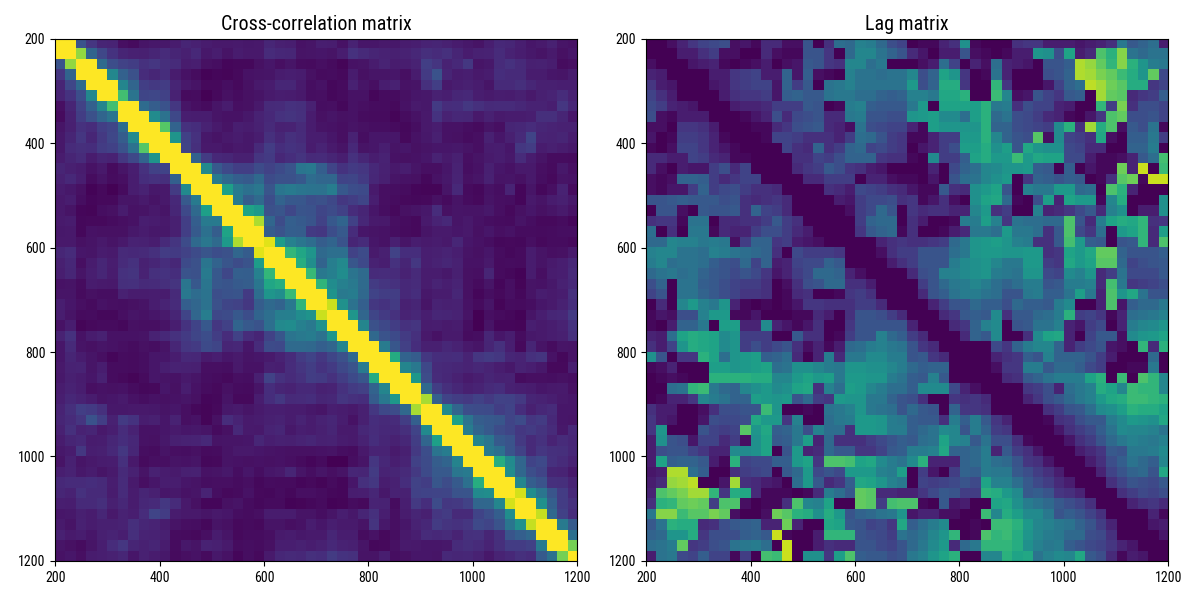

In [174]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

# cc_matrix_sm = ssg.convolve2d(cc_matrix, np.ones((3, 3)), mode='full') / 9

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmax=.5)
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmax_bin, xmin_bin], vmin=0, vmax=50)
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

### 4.1.3. <a id='toc4_1_3_'></a>Measuring correlation distance in the matrix     [&#128285;](#toc0_)

400
[26.36167496] [18.49395211]


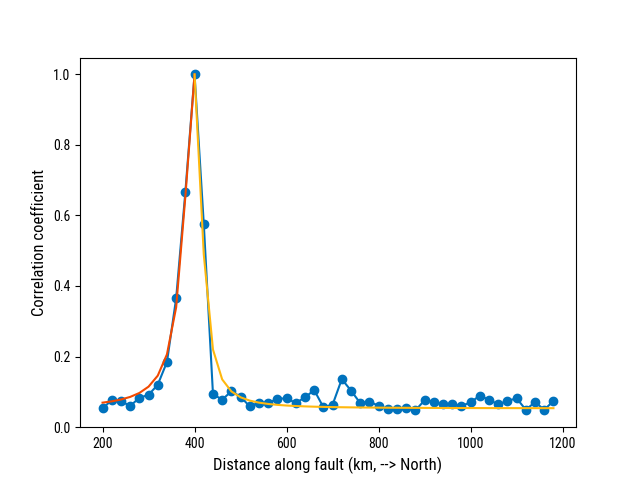

In [144]:
# Try fitting a Gaussian to get the width of the correlation
from scipy.optimize import curve_fit

ii = 10
print(x_bin_edges[ii])

x0 = x_bin_edges[ii]
def gaussian_at_x0(x, sigma):
    c = np.quantile(cc_matrix[ii, :], .10)
    return (1-c)*np.exp(-(x - x0)**2 / (2 * sigma**2)) + c

def lorentzian_at_x0(x, gamma):
    c = np.quantile(cc_matrix[ii, :], .10)
    return (1-c) / (1 + (x - x0)**2 / gamma**2) + c


# Left side fit
popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_bin_edges[:ii+1], cc_matrix[ii, :ii+1], p0=[50])
# Right side fit
popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges[ii:-1], cc_matrix[ii, ii:], p0=[50])

print(popt_left, popt_right)

# Show
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation coefficient')

ax.plot(x_bin_edges[:-1], cc_matrix[:, ii], 'o-')

ax.plot(x_bin_edges[:ii+1], lorentzian_at_x0(x_bin_edges[:ii+1], *popt_left))
ax.plot(x_bin_edges[ii:-1], lorentzian_at_x0(x_bin_edges[ii:-1], *popt_right))

plt.show()

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_3728/1058113890.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges[ii:-1], cc_matrix[ii, ii:], p0=[50, .05])
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_3728/1058113890.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_bin_edges[:ii+1], cc_matrix[ii, :ii+1], p0=[50, .05])
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_3728/1058113890.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges[ii:-1], cc_matrix[ii, ii:], p0=[50, .05])
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_3728/1058113890.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_bin_edges[:ii+

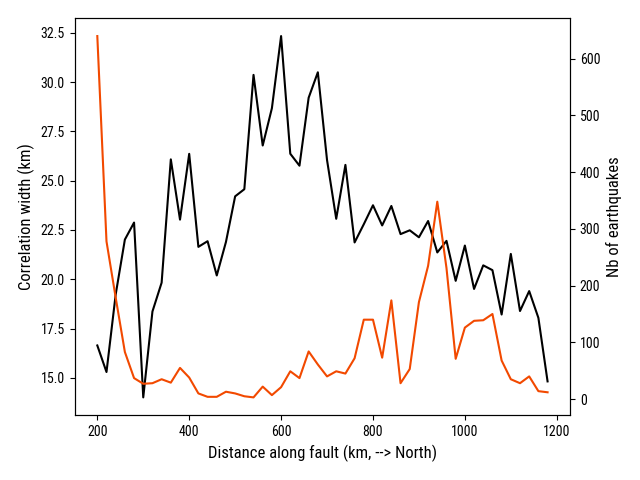

In [150]:
# Compute the correlation distances
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    x0 = x_bin_edges[ii]

    def lorentzian_at_x0(x, gamma, c):
        c = np.quantile(cc_matrix[ii, :], .10)
        return (1-c) / (1 + (x - x0)**2 / gamma**2) + c

    if ii < 10:
        popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges[ii:-1], cc_matrix[ii, ii:], p0=[50, .05])

        left_width.append(0)
        right_width.append(popt_right[0])
    elif ii > len(x_bin_edges) - 10:
        popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_bin_edges[:ii+1], cc_matrix[ii, :ii+1], p0=[50, .05])

        left_width.append(popt_left[0])
        right_width.append(0)
    else:
        popt_left, pcov_left = curve_fit(lorentzian_at_x0, x_bin_edges[:ii+1], cc_matrix[ii, :ii+1], p0=[50, .05])
        popt_right, pcov_right = curve_fit(lorentzian_at_x0, x_bin_edges[ii:-1], cc_matrix[ii, ii:], p0=[50, .05])

        left_width.append(popt_left[0])
        right_width.append(popt_right[0])

fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation width (km)')
# ax.plot(x_bin_edges[:-1], left_width, label='Left width')
# ax.plot(x_bin_edges[:-1], right_width, label='Right width')

ax.plot(x_bin_edges[:-1], [max(l, r) for l, r in zip(left_width, right_width)], label='Max width', color='k')

ax_ = ax.twinx()
n_eq_bin = np.histogram(eq_near.xf, bins=x_bin_edges)[0]
ax_.plot(x_bin_edges[:-1], n_eq_bin, label='Right width', color='C1')
ax_.set_ylabel('Nb of earthquakes')

plt.tight_layout()
plt.show()

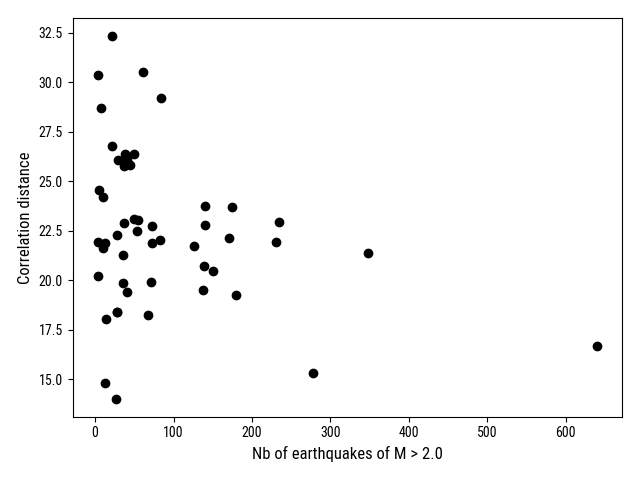

In [148]:
# Compare earthquake rate and and correlation distance
n_eq_bin = np.histogram(eq_near.xf, bins=x_bin_edges)[0]

fig, ax = plt.subplots()
ax.set_ylabel('Correlation distance')
ax.set_xlabel('Nb of earthquakes of M > {:.1f}'.format(min_m))
ax.plot(n_eq_bin, [max(l, r) for l, r in zip(left_width, right_width)], 'o', color='k')

plt.tight_layout()
plt.show()